# HEARTBEAT RECOGNITION FROM ECG

The MIT-BIH Arrhythmia Database is one of the most widely used datasets for ECG analysis.
It contains recordings collected from 47 subjects, including both normal and abnormal (arrhythmic) beats.

Each record includes the raw ECG signal, timing information, and labels indicating the heartbeat class.

The goal of this project is to develop a deep learning model capable of classifying heartbeat types from ECG dat.

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import zipfile, os

zip_path = "/content/drive/MyDrive/BIG/MIT-BIH.zip"
extract_path = "/content/MIT-BIH"

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Files extracted to:", extract_path)
print("Folder content:", os.listdir(extract_path))


Files extracted to: /content/MIT-BIH
Folder content: ['MIT-BIH.csv']


## Libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import resample
import scipy.signal as sg
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import scipy.fft as fft
from scipy.signal import savgol_filter
from scipy.signal import butter, filtfilt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score


##Dataset Analysis

The dataset consists of 180 numerical features representing ECG signal amplitudes measured at successive time steps, and one categorical target variable indicating the heartbeat type.

No missing values were found, and the signal amplitudes are mostly centered around zero with moderate variation, confirming that the data are already approximately normalized

In [5]:
import os

path = "/content/MIT-BIH"
print(os.listdir(path))


['MIT-BIH.csv']


In [6]:
train_path = "/content/MIT-BIH/MIT-BIH.csv"
df = pd.read_csv(train_path)

print("Shape:", df.shape)
print(df.head())


Shape: (107775, 182)
   Unnamed: 0         0         1         2         3         4         5  \
0           0  0.006723 -0.019156  0.032603  0.006723  0.084363  0.032603   
1           1 -0.122676 -0.200316 -0.200316 -0.252076 -0.226196 -0.174436   
2           2 -0.355596 -0.407356 -0.252076 -0.277956 -0.252076 -0.277956   
3           3 -0.200316 -0.200316 -0.226196 -0.252076 -0.200316 -0.122676   
4           4 -0.174436 -0.174436 -0.174436 -0.096796 -0.096796 -0.096796   

          6         7         8  ...       171       172       173       174  \
0  0.032603  0.006723  0.006723  ... -0.536756 -0.562636 -0.614396 -0.588516   
1 -0.122676 -0.174436 -0.174436  ... -0.562636 -0.510876 -0.510876 -0.536756   
2 -0.277956 -0.329716 -0.277956  ... -0.329716 -0.355596 -0.407356 -0.433236   
3 -0.122676 -0.148556 -0.148556  ... -0.614396 -0.614396 -0.614396 -0.588516   
4 -0.200316 -0.226196 -0.174436  ... -0.459116 -0.459116 -0.510876 -0.536756   

        175       176       177    

In [76]:
# Map numeric labels to class names
label_names = {
    0: "Fusion (F)",
    1: "Normal (N)",
    2: "Unknown (Q)",
    3: "Supraventricular (S)",
    4: "Ventricular (V)"
}

Missing values check:

In [8]:
print(df.info())
print("\nMissing values per column:")
print(df.iloc[:, 1:-1].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107775 entries, 0 to 107774
Columns: 182 entries, Unnamed: 0 to target
dtypes: float64(180), int64(2)
memory usage: 149.7 MB
None

Missing values per column:
0      0
1      0
2      0
3      0
4      0
      ..
175    0
176    0
177    0
178    0
179    0
Length: 180, dtype: int64


Displays descriptive statistics (mean, std, min, max, quartiles) for each ECG sample to check normalization and outliers.


In [9]:
df.iloc[:, 1:-1].describe().T


,count,mean,std,min,25%,50%,75%,max
0,107775.0,-0.144146,0.538266,-10.305370,-0.406733,-0.170613,0.099288,9.516257
1,107775.0,-0.143927,0.537701,-10.321963,-0.405646,-0.170412,0.098172,9.370346
2,107775.0,-0.143237,0.537072,-10.371743,-0.405907,-0.170412,0.099127,9.370346
3,107775.0,-0.142187,0.536400,-10.371743,-0.405037,-0.170238,0.098811,9.487075
4,107775.0,-0.141007,0.536050,-10.371743,-0.405037,-0.169299,0.099288,9.545439
...,...,...,...,...,...,...,...,...
175,107775.0,0.093767,0.843203,-9.400438,-0.442105,0.079881,0.607497,11.607413
176,107775.0,0.105192,0.845457,-9.380985,-0.433553,0.091264,0.619557,11.703128
177,107775.0,0.116487,0.847550,-9.264267,-0.424183,0.102787,0.636770,11.645699
178,107775.0,0.127395,0.848922,-9.322626,-0.412473,0.111470,0.649632,11.549984


Signal Statistics per Class:

In [10]:
for c in sorted(df['target'].unique()):
    samples = df.iloc[:, 1:-1][df['target'] == c].iloc[:, :-1].values
    mean_signal = np.mean(samples)
    std_signal = np.std(samples)
    print(f"Class {c}: mean={mean_signal:.3f}, std={std_signal:.3f}")


Class 0: mean=-0.007, std=1.205
Class 1: mean=0.022, std=1.103
Class 2: mean=-0.169, std=1.122
Class 3: mean=-0.035, std=1.165
Class 4: mean=-0.064, std=1.605


Average Waveform per Class:

From the class statistics and average waveforms, we can observe that each heartbeat type shows distinct temporal patterns.
For example, Normal (N) beats present a sharp, well-defined peak, while Ventricular (V) beats exhibit a wider and more irregular waveform.

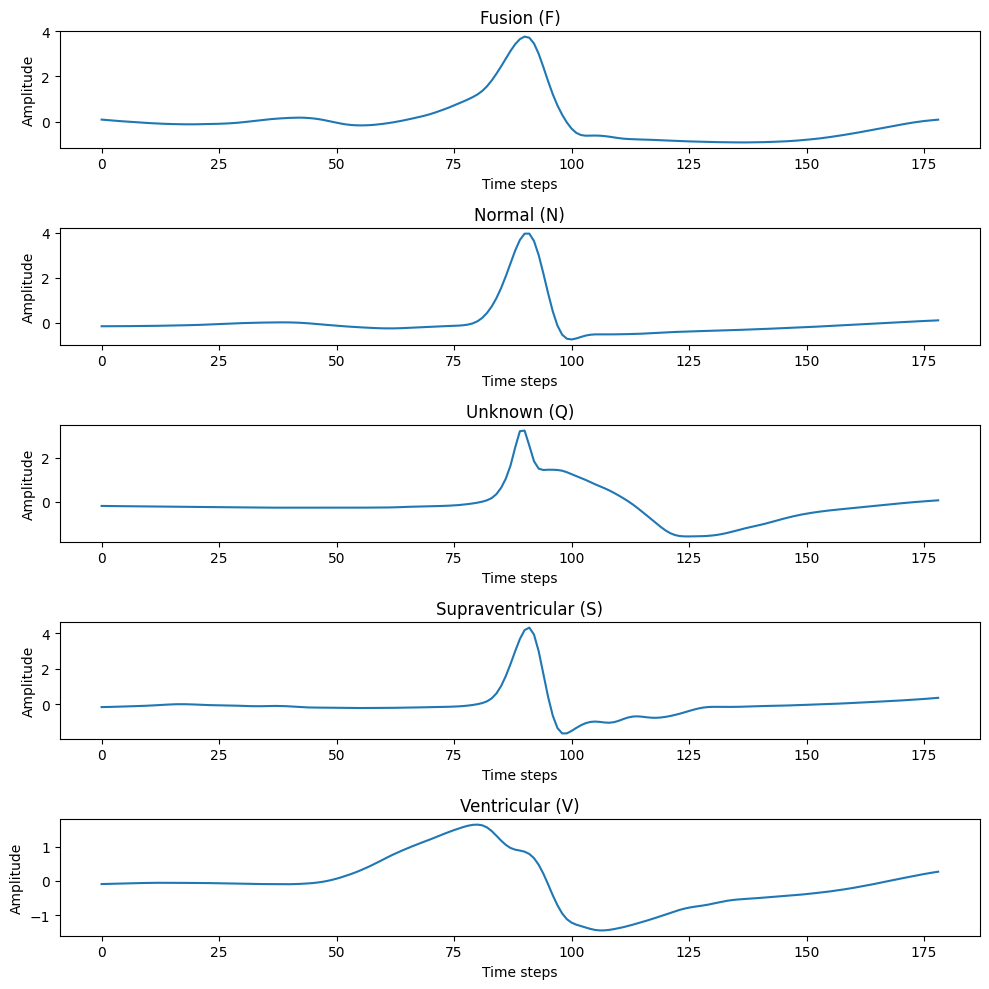

In [11]:
plt.figure(figsize=(10, 10))

for i, c in enumerate(label_names.keys()):
    plt.subplot(len(label_names), 1, i + 1)
    mean_waveform = df.iloc[:, 1:-1][df['target'] == c].iloc[:, :-1].mean().values
    plt.plot(mean_waveform, color='tab:blue')
    plt.title(label_names[c])
    plt.ylabel("Amplitude")
    plt.xlabel("Time steps")

plt.tight_layout()
plt.show()


##Preprocessing

Observing the graph I notice that the dataset is strongly unbalanced, resulting in a majority of Normal arrhythmia

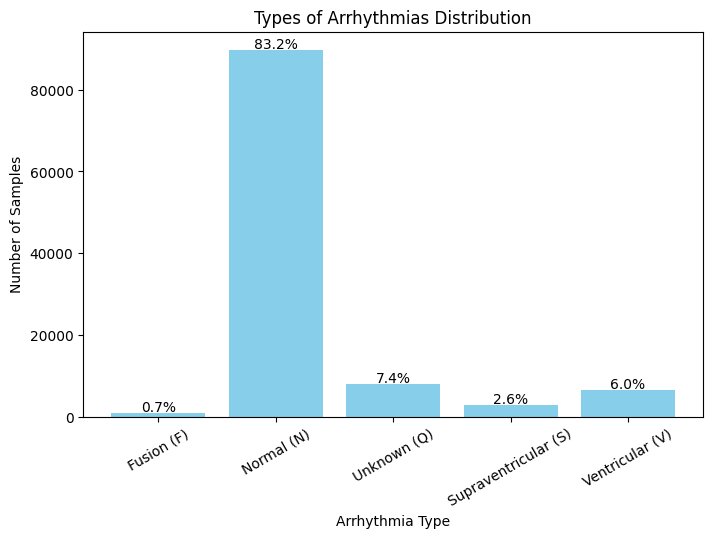

In [12]:
# Count samples per class
counts = df['target'].value_counts().sort_index()

# Plot
plt.figure(figsize=(8,5))
plt.bar(label_names.values(), counts.values, color='skyblue')
for i, v in enumerate(counts.values):
    plt.text(i, v + 500, f"{v/df.shape[0]*100:.1f}%", ha='center')


plt.title("Types of Arrhythmias Distribution")
plt.xlabel("Arrhythmia Type")
plt.ylabel("Number of Samples")
plt.xticks(rotation=30)
plt.show()


Class Balancing using Oversampling

In [13]:
# Exclude the first column (ID) and the last one ('target')
X = df.iloc[:, 1:-1].values   # ECG signals
y = df.iloc[:, -1].values     # Labels

print("Original dataset shape:", X.shape)
print("Labels shape:", y.shape)




Original dataset shape: (107775, 180)
Labels shape: (107775,)


In [14]:
# Split the dataset BEFORE balancing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Train set shape: (86220, 180)
Test set shape: (21555, 180)


In [15]:
# Create a DataFrame for balancing
train_df = pd.DataFrame(X_train)
train_df["target"] = y_train

# Oversample each class to match the largest one
classes = [train_df[train_df["target"] == c] for c in sorted(train_df["target"].unique())]
max_size = max(len(c) for c in classes)

balanced_classes = [
    resample(c, replace=True, n_samples=max_size, random_state=42)
    for c in classes
]

df_balanced_train = pd.concat(balanced_classes).sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced training dataset shape:", df_balanced_train.shape)
print(df_balanced_train["target"].value_counts())


Balanced training dataset shape: (358775, 181)
target
2    71755
4    71755
0    71755
3    71755
1    71755
Name: count, dtype: int64


In [16]:
# Separate features and labels again
X_train_bal = df_balanced_train.iloc[:, :-1].values
y_train_bal = df_balanced_train.iloc[:, -1].values

print("Balanced X_train shape:", X_train_bal.shape)
print("Balanced y_train shape:", y_train_bal.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


Balanced X_train shape: (358775, 180)
Balanced y_train shape: (358775,)
X_test shape: (21555, 180)
y_test shape: (21555,)


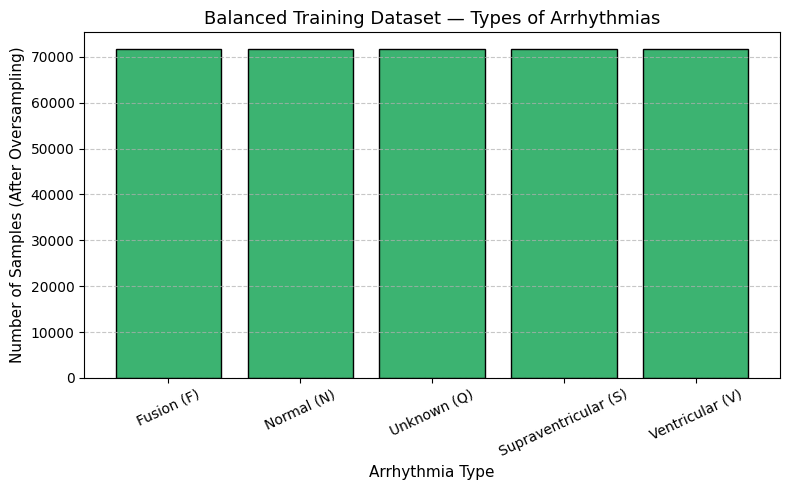

In [17]:
counts_bal = df_balanced_train['target'].value_counts().sort_index()


plt.figure(figsize=(8,5))
plt.bar(label_names.values(), counts_bal.values, color='mediumseagreen', edgecolor='black')


plt.title("Balanced Training Dataset — Types of Arrhythmias", fontsize=13)
plt.xlabel("Arrhythmia Type", fontsize=11)
plt.ylabel("Number of Samples (After Oversampling)", fontsize=11)
plt.xticks(rotation=25)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [18]:
#Possible overlaps
train_signals = set(map(tuple, X_train.reshape(len(X_train), -1)))
test_signals = set(map(tuple, X_test.reshape(len(X_test), -1)))

overlap = train_signals.intersection(test_signals)
print("Possible overlaps:", len(overlap))


Possible overlaps: 0


Noise Filtering

Before applying denoising technique, we analyze the frequency spectrum
of the ECG signals..
The frequency-domain plot shows that most of the useful information
is concentrated between approximately 2 Hz and 14 Hz,
while higher frequencies mainly contain noise components.

Significant frequency range: 2.0 Hz to 13.9 Hz


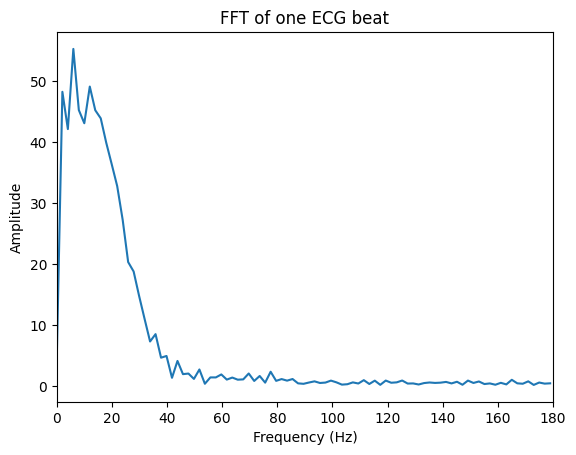

In [19]:
signal = df.iloc[0, :-1].values

#sampling rate
fs = 360

# compute FFT
xf = fft.rfftfreq(len(signal), d=1/fs)
yf = np.abs(fft.rfft(signal))

threshold = np.percentile(yf, 95)  # ad esempio il 95° percentile
significant_freqs = xf[yf > threshold]

print("Significant frequency range: {:.1f} Hz to {:.1f} Hz".format(significant_freqs.min(), significant_freqs.max()))

# opzionale: plottare spettro
import matplotlib.pyplot as plt
plt.plot(xf, yf)
plt.xlim(0, fs/2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("FFT of one ECG beat")
plt.show()


Based on this observation,a 4th-order Butterworth band-pass filter with cutoff frequencies between 1 Hz and 40 Hz is applied.
This range removes both low-frequency baseline
and high-frequency noise while preserving the essential ECG morphology.

In [20]:
fs = 360.0   # Sampling frequency (Hz)
lowcut = 1.0 # Low cutoff frequency
highcut = 40.0 # High cutoff frequency

# 4th order Butterworth bandpass filter
b, a = butter(
    N=4,
    Wn=[lowcut / (0.5 * fs), highcut / (0.5 * fs)],
    btype='band'
)

# Apply separately on training and test sets
X_train_filtered = filtfilt(b, a, X_train_bal, axis=1)
X_test_filtered = filtfilt(b, a, X_test, axis=1)

print("X_train_bal shape:", X_train_bal.shape)
print("X_train_filtered shape:", X)



X_train_bal shape: (358775, 180)
X_train_filtered shape: [[ 0.0067235  -0.01915648  0.03260348 ... -0.64027596 -0.58851601
  -0.64027596]
 [-0.12267639 -0.20031633 -0.20031633 ... -0.58851601 -0.61439599
  -0.56263603]
 [-0.3555962  -0.40735616 -0.25207629 ... -0.30383624 -0.40735616
  -0.38147618]
 ...
 [-0.21986782 -0.21986782 -0.21986782 ... -0.30876263 -0.32357843
  -0.29394682]
 [-0.33839423 -0.32357843 -0.32357843 ... -0.29394682 -0.30876263
  -0.36802583]
 [-0.21986782 -0.19023622 -0.13097302 ... -0.16060462 -0.19023622
  -0.19023622]]


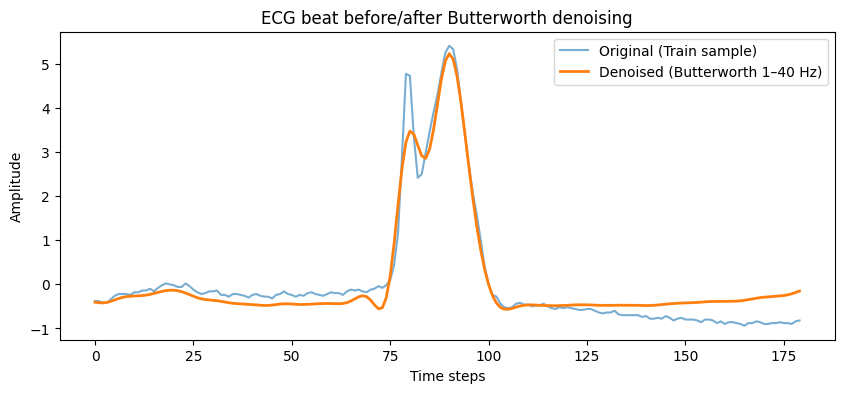

In [21]:
idx = 25

plt.figure(figsize=(10, 4))
plt.plot(X_train_bal[idx], label="Original (Train sample)", alpha=0.6)
plt.plot(X_train_filtered[idx], label="Denoised (Butterworth 1–40 Hz)", linewidth=2)

plt.title("ECG beat before/after Butterworth denoising")
plt.xlabel("Time steps")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


After applying the Butterworth band-pass filter (1–40 Hz), I apply a Savitzky–Golay smoothing filter.
The Savitzky–Golay filter performs a local smoothing that reduces minor fluctuations while mantaining the morphological features of the ECG waveform.

In [22]:
# Apply Savitzky-Golay smoothing after Butterworth
X_train_savgol = savgol_filter(X_train_filtered, window_length=9, polyorder=3, axis=1)
X_test_savgol = savgol_filter(X_test_filtered, window_length=9, polyorder=3, axis=1)

print("X_train_savgol shape:", X_train_savgol.shape)
print("X_test_savgol shape:", X_test_savgol.shape)


X_train_savgol shape: (358775, 180)
X_test_savgol shape: (21555, 180)


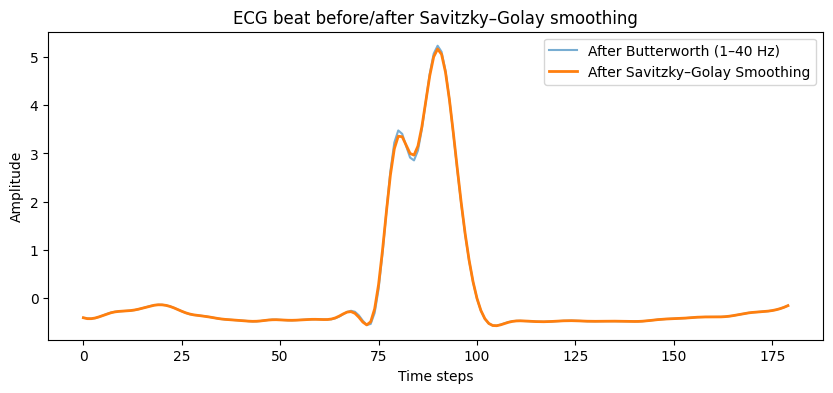

In [23]:
idx = 25

plt.figure(figsize=(10,4))
plt.plot(X_train_filtered[idx], label='After Butterworth (1–40 Hz)', alpha=0.6)
plt.plot(X_train_savgol[idx], label='After Savitzky–Golay Smoothing', linewidth=2)
plt.title("ECG beat before/after Savitzky–Golay smoothing")
plt.xlabel("Time steps")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

The ECG signals are already normalized (mean ≈ 0, std ≈ 1), so no additional scaling is applied before training.

In [24]:
mean_val = np.mean(X_train_savgol)
std_val = np.std(X_train_savgol)
min_val = np.min(X_train_savgol)
max_val = np.max(X_train_savgol)

print(f"Mean: {mean_val:.4f}")
print(f"Standard deviation: {std_val:.4f}")
print(f"Min: {min_val:.4f}")
print(f"Max: {max_val:.4f}")


Mean: 0.0395
Standard deviation: 1.0941
Min: -12.7518
Max: 9.4716


The preprocessing phase involved several key steps.
First, we analyzed the class distribution and applied oversampling to handle the strong imbalance between heartbeat types.
Then, we performed a frequency-domain analysis (FFT) to identify the meaningful frequency range of ECG signals and applied a Butterworth band-pass filter (1–40 Hz) to remove baseline wander and high-frequency noise.
Finally, we applied a Savitzky–Golay smoothing filter to reduce minor fluctuations while preserving the morphology of the ECG waveforms.

The resulting signals are clean, balanced, and already normalized, making them suitable for deep learning model training.

##CNN Customization

In [25]:
X_train_bal = X_train_savgol[..., np.newaxis]
X_test_bal= X_test_savgol[..., np.newaxis]


In [26]:
# Add a new dimension to match the CNN input shape
X_train_bal = np.expand_dims(X_train_bal, axis=1)
X_test = np.expand_dims(X_test, axis=1)

print("Final shapes:")
print("X_train_bal:", X_train_bal.shape)
print("X_test:", X_test.shape)


Final shapes:
X_train_bal: (358775, 1, 180, 1)
X_test: (21555, 1, 180)


In [27]:
X_train_bal = np.squeeze(X_train_bal)
X_test = np.squeeze(X_test)


In [28]:
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx].unsqueeze(0)  # (180,) → (1, 180)
        y = self.y[idx]
        return x, y

# Create train and test datasets
train_dataset = ECGDataset(X_train_bal, y_train_bal)
test_dataset = ECGDataset(X_test, y_test)

# Define dataloaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Train samples: 358775
Test samples: 21555


The model is a custom 1D Convolutional Neural Network (CNN) designed to classify ECG heartbeats.
It consists of three convolutional blocks with batch normalization and max pooling, followed by two fully connected layers.
The convolutional layers capture local temporal features in the ECG signal, while the dense layers integrate these representations for final classification across the five heartbeat categories.

In [29]:
class ECGCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(ECGCNN, self).__init__()

        # First convolutional block
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2)

        # Second convolutional block
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)

        # Third convolutional block
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 22, 128)  # 180 -> 90 -> 45 -> 22 after pooling
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Forward propagation
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Instantiate the model
model = ECGCNN(num_classes=5)
print(model)


ECGCNN(
  (conv1): Conv1d(1, 32, kernel_size=(7,), stride=(1,), padding=(3,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2816, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


##Training Phase

The CNN model was trained for 20 epochs using the Adam optimizer (learning rate = 0.001) and CrossEntropy loss.
The training and validation performance were monitored over epochs to assess convergence and generalization.

In [31]:
from tqdm.notebook import tqdm

num_epochs = 20
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Progress bar for training batches
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
    for X_batch, y_batch in loop:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())  # show live loss

    # Average training loss
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate on test set
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    # Print summary for current epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_train_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

print("Training complete!")


Epoch [1/20]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [1/20] - Loss: 0.1375, Test Accuracy: 71.70%


Epoch [2/20]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [2/20] - Loss: 0.0623, Test Accuracy: 72.73%


Epoch [3/20]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [3/20] - Loss: 0.0438, Test Accuracy: 73.70%


Epoch [4/20]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [4/20] - Loss: 0.0336, Test Accuracy: 73.75%


Epoch [5/20]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [5/20] - Loss: 0.0278, Test Accuracy: 71.32%


Epoch [6/20]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [6/20] - Loss: 0.0227, Test Accuracy: 78.86%


Epoch [7/20]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [7/20] - Loss: 0.0203, Test Accuracy: 77.23%


Epoch [8/20]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [8/20] - Loss: 0.0170, Test Accuracy: 79.03%


Epoch [9/20]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [9/20] - Loss: 0.0157, Test Accuracy: 74.48%


Epoch [10/20]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [10/20] - Loss: 0.0143, Test Accuracy: 80.94%


Epoch [11/20]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [11/20] - Loss: 0.0126, Test Accuracy: 78.21%


Epoch [12/20]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [12/20] - Loss: 0.0116, Test Accuracy: 81.36%


Epoch [13/20]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [13/20] - Loss: 0.0104, Test Accuracy: 82.28%


Epoch [14/20]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [14/20] - Loss: 0.0105, Test Accuracy: 82.83%


Epoch [15/20]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [15/20] - Loss: 0.0101, Test Accuracy: 79.34%


Epoch [16/20]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [16/20] - Loss: 0.0085, Test Accuracy: 78.54%


Epoch [17/20]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [17/20] - Loss: 0.0084, Test Accuracy: 79.05%


Epoch [18/20]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [18/20] - Loss: 0.0083, Test Accuracy: 82.22%


Epoch [19/20]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [19/20] - Loss: 0.0076, Test Accuracy: 83.58%


Epoch [20/20]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [20/20] - Loss: 0.0073, Test Accuracy: 83.24%
Training complete!


##Model Evaluation

Evaluation metrics include accuracy, precision, recall, F1-score, ROC-AUC, and Precision–Recall AUC for each heartbeat class.
These metrics provide a comprehensive understanding of the model performance.

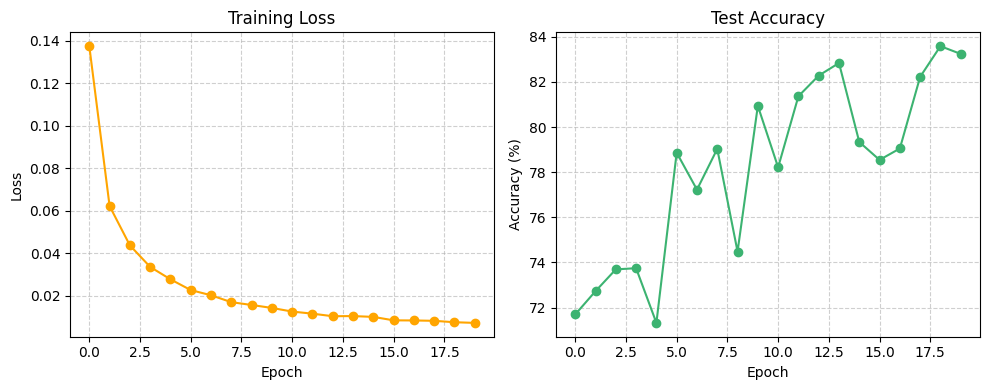

In [32]:
plt.figure(figsize=(10, 4))

# Training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, color='orange', marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, linestyle="--", alpha=0.6)

# Test accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, color='mediumseagreen', marker='o')
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


Test Accuracy: 83.24%

Classification Report:
                      precision    recall  f1-score   support

          Fusion (F)     0.3966    0.2949    0.3382       156
          Normal (N)     0.9844    0.8216    0.8957     17939
         Unknown (Q)     0.8317    0.9881    0.9032      1600
Supraventricular (S)     0.1906    0.6146    0.2910       563
     Ventricular (V)     0.4471    0.9483    0.6077      1297

            accuracy                         0.8324     21555
           macro avg     0.5701    0.7335    0.6072     21555
        weighted avg     0.9158    0.8324    0.8591     21555



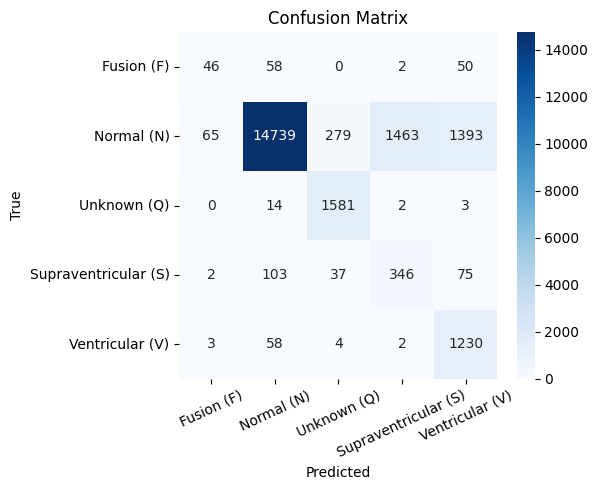

In [33]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {acc*100:.2f}%\n")

# Classification report
labels_sorted = sorted(label_names.keys())
target_names = [label_names[c] for c in labels_sorted]

print("Classification Report:")
print(classification_report(y_true, y_pred, labels=labels_sorted, target_names=target_names, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=labels_sorted)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()


The ROC and Precision–Recall curves indicate that the model performs well for Normal and Unknown beats, while the recognition of minority classes (Fusion and Supraventricular) remains challenging.

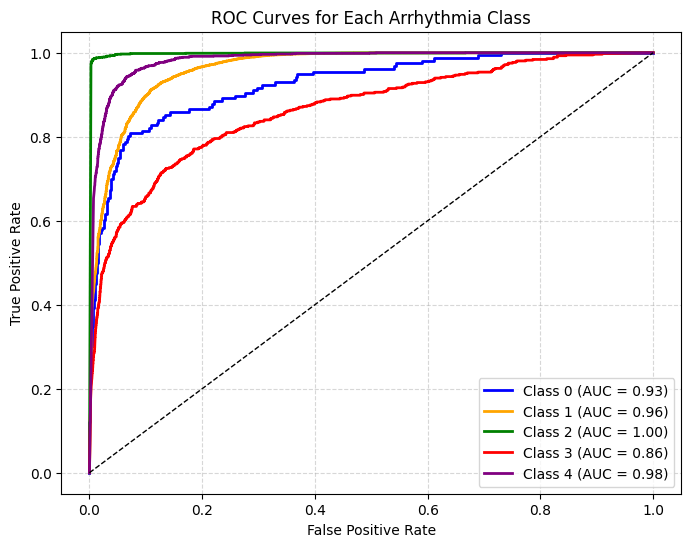

Micro-average AUC: 0.975
Macro-average AUC: 0.951


In [34]:
model.eval()

all_labels = []
all_probs = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(next(model.parameters()).device)
        outputs = model(X_batch)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        all_probs.append(probs)
        all_labels.append(y_batch.cpu().numpy())


all_probs = np.concatenate(all_probs)
all_labels = np.concatenate(all_labels)


n_classes = len(np.unique(all_labels))
y_bin = label_binarize(all_labels, classes=range(n_classes))


fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), all_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
roc_auc["macro"] = np.mean(list(roc_auc.values()))

# Plot ROC
plt.figure(figsize=(8, 6))
colors = ['blue', 'orange', 'green', 'red', 'purple']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Arrhythmia Class')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# AUC
print(f"Micro-average AUC: {roc_auc['micro']:.3f}")
print(f"Macro-average AUC: {roc_auc['macro']:.3f}")


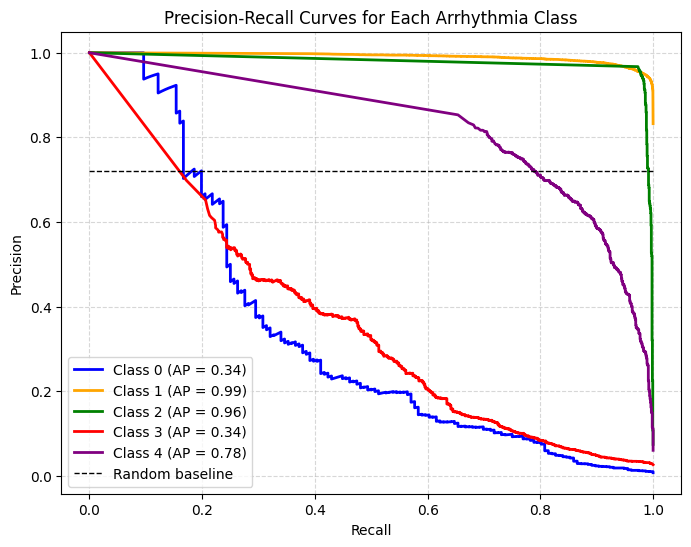

Micro-average Precision-Recall AUC: 0.909
Macro-average Precision-Recall AUC: 0.720


In [35]:
precision = dict()
recall = dict()
avg_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], all_probs[:, i])
    avg_precision[i] = average_precision_score(y_bin[:, i], all_probs[:, i])

precision["micro"], recall["micro"], _ = precision_recall_curve(y_bin.ravel(), all_probs.ravel())
avg_precision["micro"] = average_precision_score(y_bin, all_probs, average="micro")
avg_precision["macro"] = np.mean(list(avg_precision.values()))

# Plot Precision-Recall
plt.figure(figsize=(8, 6))
colors = ['blue', 'orange', 'green', 'red', 'purple']

for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], lw=2, color=color,
             label=f'Class {i} (AP = {avg_precision[i]:.2f})')

plt.plot([0, 1], [np.mean(list(avg_precision.values()))]*2, 'k--', lw=1, label='Random baseline')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Each Arrhythmia Class')
plt.legend(loc="lower left")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

print(f"Micro-average Precision-Recall AUC: {avg_precision['micro']:.3f}")
print(f"Macro-average Precision-Recall AUC: {avg_precision['macro']:.3f}")


In [36]:
torch.save(model.state_dict(), "ecg_best_model.pth")
print("Modello salvato come ecg_best_model.pth")


Modello salvato come ecg_best_model.pth


##Most Relevant ECG Features

To interpret the CNN’s decision process, two explainability techniques were applied:

**1. Grad-CAM (Gradient-weighted Class Activation Mapping)**  
Grad-CAM highlights the most relevant temporal regions in the ECG signal that contribute to the model’s prediction.  
It computes the gradient of the output score with respect to the activations of the last convolutional layer, identifying the signal segments that most influence the classification.

**2. Occlusion Sensitivity**  
This method systematically occludes small portions of the ECG signal and measures how much the model’s confidence drops.  
Regions where occlusion causes a strong confidence decrease are considered highly important for the decision.

Grad-CAM for a 1D CNN model

In [54]:
def grad_cam_1d(model, x, target_class):
    """
    Computes Grad-CAM for a 1D CNN model.
    Args:
        model: trained CNN model
        x: input tensor of shape (1, 1, L)
        target_class: int (true or predicted class)
    Returns:
        cam: Grad-CAM activation map (numpy array)
    """
    model.eval()

    # Hooks to capture activations and gradients
    activations = {}
    gradients = {}

    def forward_hook(module, input, output):
        activations["value"] = output.detach()

    def backward_hook(module, grad_in, grad_out):
        gradients["value"] = grad_out[0].detach()

    # Register hooks on the last conv layer
    handle_f = model.conv3.register_forward_hook(forward_hook)
    handle_b = model.conv3.register_backward_hook(backward_hook)

    # Forward + backward
    x = x.clone().detach().requires_grad_(True)
    output = model(x)
    loss = output[0, target_class]
    loss.backward()

    # Get gradients and activations
    grads = gradients["value"]          # (B, C, L)
    acts = activations["value"]         # (B, C, L)

    # Global average pooling of gradients
    weights = grads.mean(dim=2, keepdim=True)   # (B, C, 1)

    # Weighted sum of activations
    cam = (weights * acts).sum(dim=1).clamp(min=0)  # ReLU
    cam = cam.squeeze().cpu().numpy()

    # Normalize for visualization
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    # Remove hooks
    handle_f.remove()
    handle_b.remove()

    return cam


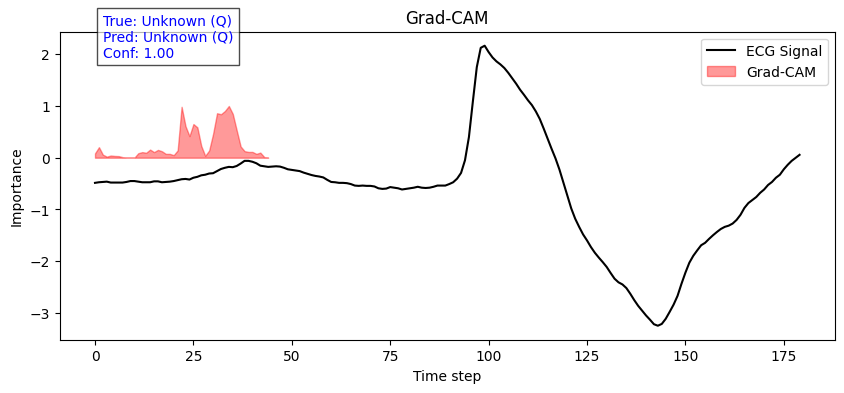

In [92]:
label_names = {
    0: "Fusion (F)",
    1: "Normal (N)",
    2: "Unknown (Q)",
    3: "Supraventricular (S)",
    4: "Ventricular (V)"
}

idx = 121

sample, label = test_loader.dataset[idx]
sample = sample.unsqueeze(0).to(device)   # (1, 1, 180)
true_label = label.item() if hasattr(label, "item") else int(label)

with torch.no_grad():
    outputs = model(sample)
    probs = torch.softmax(outputs, dim=1)
    pred_class = torch.argmax(probs, dim=1).item()
    pred_conf = probs[0, pred_class].item()


cam = grad_cam_1d(model, sample, target_class=true_label)


true_name = label_names.get(true_label, f"Class {true_label}")
pred_name = label_names.get(pred_class, f"Class {pred_class}")


plt.figure(figsize=(10, 4))
plt.plot(sample.cpu().squeeze(), label="ECG Signal", color="black")
plt.fill_between(np.arange(len(cam)), 0, cam, color="red", alpha=0.4, label="Grad-CAM")


plt.text(2, sample.cpu().squeeze().max()*0.9,
         f"True: {true_name}\nPred: {pred_name}\nConf: {pred_conf:.2f}",
         fontsize=10, color='blue', bbox=dict(facecolor='white', alpha=0.7))

plt.title("Grad-CAM")
plt.xlabel("Time step")
plt.ylabel("Importance")
plt.legend()
plt.show()




Occlusion sensitivity

In [56]:
def occlusion_sensitivity(model, x, window_size=10, baseline=0.0):
    """
    model: your trained ECGCNN
    x: input tensor (1, 1, L)
    window_size: how many time steps to mask at once
    baseline: value to put when we occlude (0.0 is ok for normalized signals)
    """
    model.eval()
    x = x.clone().detach()
    device = next(model.parameters()).device
    x = x.to(device)

    # get original prediction confidence
    with torch.no_grad():
        out = model(x)
        probs = torch.softmax(out, dim=1)
        pred_class = probs.argmax(dim=1).item()
        base_conf = probs[0, pred_class].item()

    L = x.shape[-1]
    importance = np.zeros(L)

    # slide a window over the signal
    for start in range(0, L, window_size):
        end = min(start + window_size, L)

        x_occ = x.clone()
        x_occ[:, :, start:end] = baseline  # occlude this segment

        with torch.no_grad():
            out_occ = model(x_occ)
            probs_occ = torch.softmax(out_occ, dim=1)
            conf_occ = probs_occ[0, pred_class].item()

        drop = base_conf - conf_occ  # how much confidence we lost
        importance[start:end] = drop

    return importance, pred_class, base_conf


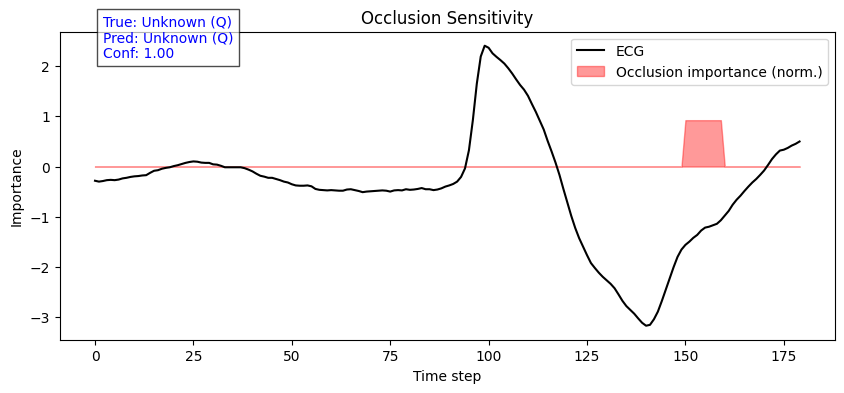

In [91]:
label_names = {
    0: "Fusion (F)",
    1: "Normal (N)",
    2: "Unknown (Q)",
    3: "Supraventricular (S)",
    4: "Ventricular (V)"
}

idx = 121
sample, label = test_loader.dataset[idx]
sample = sample.unsqueeze(0).to(next(model.parameters()).device)  # (1, 1, 180)


importance, pred_class, base_conf = occlusion_sensitivity(
    model,
    sample,
    window_size=10,
    baseline=0.0
)

# --- Info ---
true_label = label.item() if hasattr(label, "item") else int(label)
true_name = label_names.get(true_label, f"Class {true_label}")
pred_name = label_names.get(pred_class, f"Class {pred_class}")


signal = sample.cpu().squeeze().numpy()  # (180,)

plt.figure(figsize=(10, 4))
plt.plot(signal, label="ECG", color="black")
plt.fill_between(
    np.arange(len(signal)),
    0,
    importance / (importance.max() + 1e-8),
    color="red",
    alpha=0.4,
    label="Occlusion importance (norm.)"
)


plt.text(
    2, signal.max() * 0.9,
    f"True: {true_name}\nPred: {pred_name}\nConf: {base_conf:.2f}",
    fontsize=10,
    color="blue",
    bbox=dict(facecolor="white", alpha=0.7)
)

plt.title("Occlusion Sensitivity")
plt.xlabel("Time step")
plt.ylabel("Importance")
plt.legend()
plt.show()


##LSTM for ECG

To explore how temporal modeling could improve performance, a bidirectional LSTM network is implemented.
The model includes two LSTM layers with 128 hidden units, followed by fully connected layers with ReLU activation and dropout for regularization.

While this architecture should, in theory, capture long-term temporal dependencies in ECG signals, its performance turns out to be lower than the CNN model, reaching a test accuracy of around 69.8%.
The confusion matrix shows that the LSTM performed well on normal beats but has difficulty identifying the minority arrhythmia classes.

In [37]:
class ECGLSTM(nn.Module):
    def __init__(
        self,
        num_classes=5,
        input_size=1,
        hidden_size=128,
        num_layers=2,
        bidirectional=True,
        dropout=0.3,
    ):
        super().__init__()
        self.bidirectional = bidirectional

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0,
        )

        dim_fc = hidden_size * (2 if bidirectional else 1)
        self.fc = nn.Sequential(
            nn.Linear(dim_fc, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # Input: (batch, 1, 180) → Expected: (batch, 180, 1)
        x = x.permute(0, 2, 1)

        out, (h, c) = self.lstm(x)

        if self.bidirectional:
            # Concatenate the last hidden states from both directions
            h_fwd = h[-2, :, :]
            h_bwd = h[-1, :, :]
            h_cat = torch.cat((h_fwd, h_bwd), dim=1)
            logits = self.fc(h_cat)
        else:
            h_last = h[-1, :, :]
            logits = self.fc(h_last)

        return logits



In [38]:
lstm_model = ECGLSTM(num_classes=5).to(next(model.parameters()).device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

Training Phase LSTM

In [39]:
device = next(lstm_model.parameters()).device


In [42]:
from tqdm.notebook import tqdm

num_epochs = 25
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    lstm_model.train()
    running_loss = 0.0

    # Progress bar for training batches
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
    for X_batch, y_batch in loop:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = lstm_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())  # show live loss

    # Average training loss
    avg_train_loss = running_loss / len(loop)
    train_losses.append(avg_train_loss)

    # Evaluate on test set
    lstm_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = lstm_model(X_batch)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    # Print summary for current epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_train_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

print("Training complete!")


Epoch [1/25]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [1/25] - Loss: 0.0729, Test Accuracy: 60.38%


Epoch [2/25]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [2/25] - Loss: 0.0550, Test Accuracy: 61.29%


Epoch [3/25]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [3/25] - Loss: 0.0423, Test Accuracy: 61.72%


Epoch [4/25]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [4/25] - Loss: 0.0356, Test Accuracy: 67.54%


Epoch [5/25]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [5/25] - Loss: 0.0312, Test Accuracy: 62.48%


Epoch [6/25]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [6/25] - Loss: 0.0266, Test Accuracy: 66.42%


Epoch [7/25]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [7/25] - Loss: 0.0249, Test Accuracy: 67.18%


Epoch [8/25]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [8/25] - Loss: 0.0207, Test Accuracy: 64.05%


Epoch [9/25]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [9/25] - Loss: 0.0189, Test Accuracy: 66.49%


Epoch [10/25]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [10/25] - Loss: 0.0184, Test Accuracy: 67.06%


Epoch [11/25]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [11/25] - Loss: 0.0163, Test Accuracy: 70.23%


Epoch [12/25]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [12/25] - Loss: 0.0164, Test Accuracy: 64.93%


Epoch [13/25]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [13/25] - Loss: 0.0144, Test Accuracy: 62.93%


Epoch [14/25]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [14/25] - Loss: 0.0134, Test Accuracy: 69.16%


Epoch [15/25]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [15/25] - Loss: 0.0125, Test Accuracy: 67.15%


Epoch [16/25]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [16/25] - Loss: 0.0103, Test Accuracy: 68.43%


Epoch [17/25]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [17/25] - Loss: 0.0113, Test Accuracy: 70.75%


Epoch [18/25]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [18/25] - Loss: 0.0124, Test Accuracy: 64.33%


Epoch [19/25]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [19/25] - Loss: 0.0105, Test Accuracy: 67.50%


Epoch [20/25]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [20/25] - Loss: 0.0086, Test Accuracy: 70.79%


Epoch [21/25]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [21/25] - Loss: 0.0086, Test Accuracy: 68.76%


Epoch [22/25]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [22/25] - Loss: 0.0084, Test Accuracy: 69.62%


Epoch [23/25]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [23/25] - Loss: 0.0081, Test Accuracy: 69.49%


Epoch [24/25]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [24/25] - Loss: 0.0077, Test Accuracy: 69.25%


Epoch [25/25]:   0%|          | 0/2803 [00:00<?, ?it/s]

Epoch [25/25] - Loss: 0.0067, Test Accuracy: 69.80%
Training complete!


Evaluation Phase LSTM

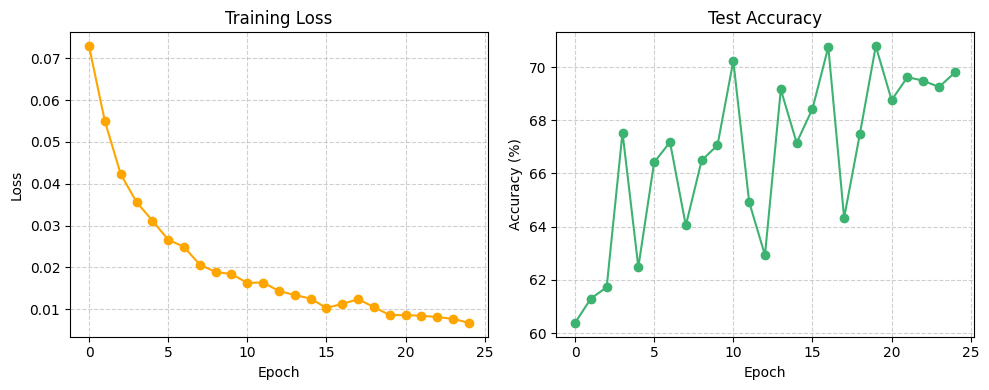

In [43]:
plt.figure(figsize=(10, 4))

# Training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, color='orange', marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, linestyle="--", alpha=0.6)

# Test accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, color='mediumseagreen', marker='o')
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


Test Accuracy: 69.80%

Classification Report:
                      precision    recall  f1-score   support

          Fusion (F)     0.0663    0.2436    0.1043       156
          Normal (N)     0.9562    0.7056    0.8120     17939
         Unknown (Q)     0.5188    0.8612    0.6476      1600
Supraventricular (S)     0.1296    0.2380    0.1678       563
     Ventricular (V)     0.2067    0.6461    0.3132      1297

            accuracy                         0.6980     21555
           macro avg     0.3755    0.5389    0.4089     21555
        weighted avg     0.8506    0.6980    0.7478     21555



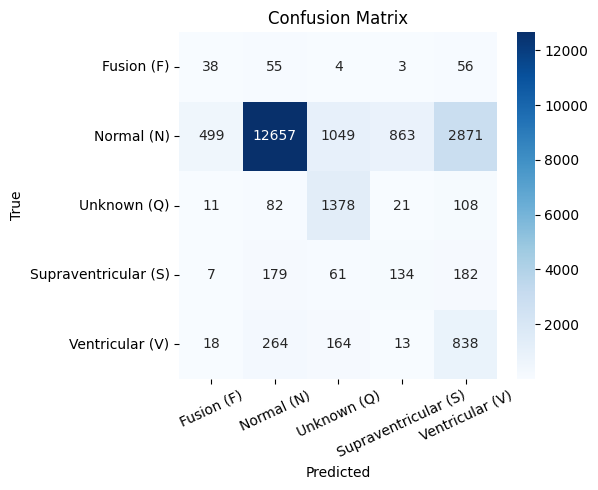

In [44]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = lstm_model(X_batch)
        _, preds = torch.max(outputs, 1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {acc*100:.2f}%\n")

# Classification report
labels_sorted = sorted(label_names.keys())
target_names = [label_names[c] for c in labels_sorted]

print("Classification Report:")
print(classification_report(y_true, y_pred, labels=labels_sorted, target_names=target_names, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=labels_sorted)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()


These results suggest that CNNs are generally better suited for ECG classification, as they can more effectively detect localized waveform features such as P-QRS-T complexes.
For this reason, the CNN model was ultimately selected as the final architecture.